In [41]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from time import time

# sample data

In [42]:
# parameters
m = 10
p = 5
noise = 0.01
option = 2
random_state = 46
rng = np.random.RandomState(random_state)

In [43]:
def sample_data(m, p, noise, rng):
    # causal effect matrices
    B = rng.normal(size=(m, p, p))
    for i in range(m):
        B[i][np.triu_indices(p, k=0)] = 0  # set the strictly upper triangular part to 0

    # causal order
    P = np.eye(p)
    rng.shuffle(P)

    # permute rows and columns of B
    B_shuffled = np.array([P.T @ Bi @ P for Bi in B])

    # add noise
    N = noise * rng.normal(size=(m, p, p))
    B_hat = B_shuffled + N
    
    return B_hat, P

B_hat, P = sample_data(m, p, noise, rng)
true_order = np.argmax(P, axis=1)

# retrieve causal order P

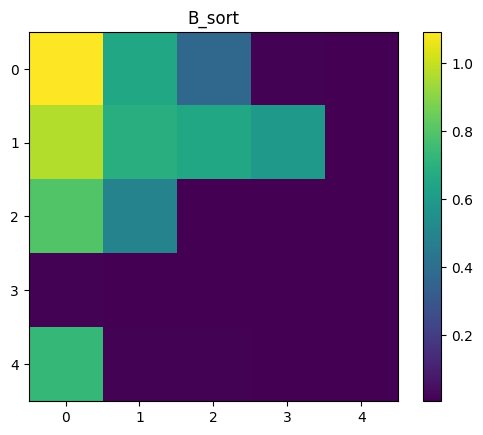

In [44]:
if option == 1:
    B_avg = np.mean(B_hat, axis=0)
    B_sort = np.sort(np.abs(B_avg), axis=1)[:, ::-1]
elif option == 2:
    B_avg = np.mean(np.abs(B_hat), axis=0)
    B_sort = np.sort(B_avg, axis=1)[:, ::-1]

plt.imshow(B_sort)
plt.title("B_sort")
plt.colorbar()
plt.show()

In [45]:
B_argsort = np.argsort(B_sort, axis=0)
B_argsort

array([[3, 3, 2, 3, 3],
       [4, 4, 3, 2, 0],
       [2, 2, 4, 4, 1],
       [1, 0, 0, 0, 4],
       [0, 1, 1, 1, 2]])

In [46]:
order = []
for i in range(p):
    col = B_argsort[:, i]
    available_id = ~np.isin(col, order)
    first_id = np.argmax(available_id)
    order.append(col[first_id])

In [47]:
success = (order == true_order).all()

if success:
    print("The causal order is retrieved!")
else:
    print("The causal order is not retrieved.")

The causal order is retrieved!


# plot obtained matrices B

In [48]:
P = np.eye(p)[order]
B_tilde = P @ B_hat @ P.T

In [49]:
# plot heat maps of causal effect matrices
def heat_maps_B(B, absolute_value=True):
    m, p, _ = B.shape
    fontsize = 18
    fig, axes = plt.subplots(1, m, figsize=(m*5, 5))
    if absolute_value:
        vmin = 0
    else:
        vmin = np.min(B)
    for i, ax in enumerate(axes.flat):
        if absolute_value:
            Bi = np.abs(B[i])
        else:
            Bi = B[i]
        im = ax.imshow(Bi, vmin=vmin, vmax=np.max(B), cmap="copper")
        ax.set_title(f"View {i}", fontsize=fontsize)
    cbar = fig.colorbar(im, ax=axes, fraction=0.0042, pad=0.015)
    cbar.set_label('Color Scale', fontsize=fontsize)
    if absolute_value:
        title_sup = "(in absolute value)"
    else:
        title_sup = ""
    fig.suptitle(
        f"Causal effect matrices {title_sup} after retrieving permutation P",
        fontsize=fontsize)
    fig.supxlabel("components", fontsize=fontsize)
    fig.supylabel("components", fontsize=fontsize, x=0.11)
    plt.show()

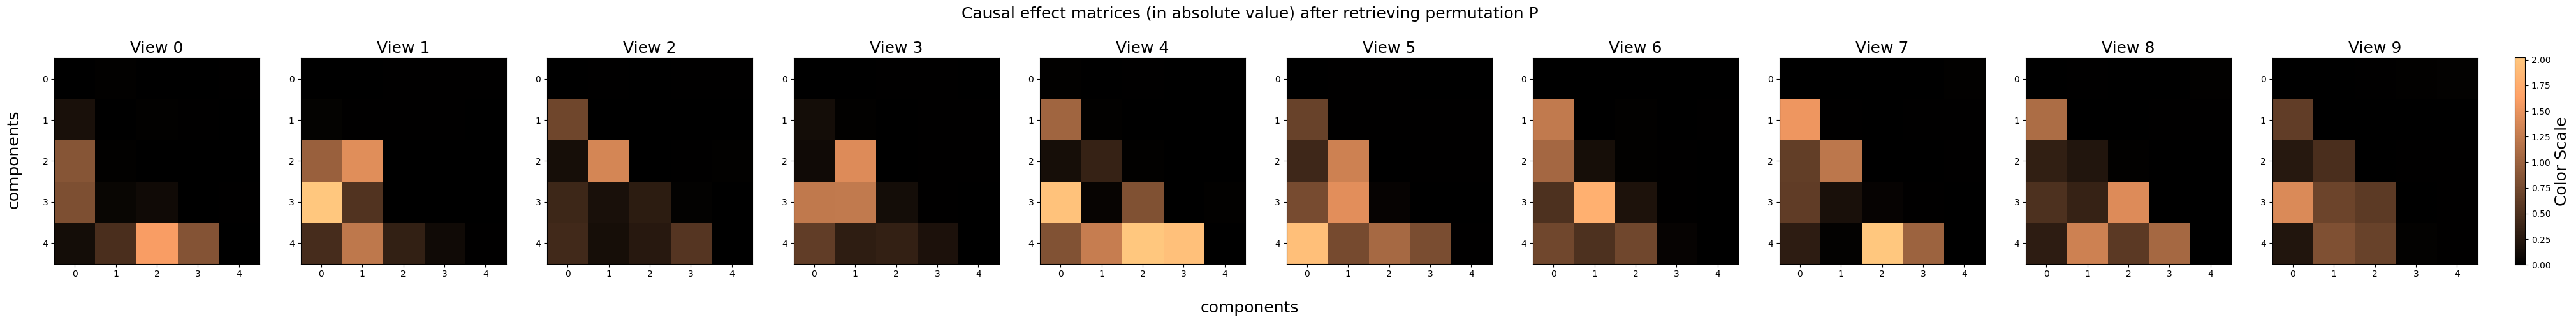

In [50]:
heat_maps_B(B_tilde)

Causal matrices are now strictly lower triangular, as expected!

# compare the 2 options for B_sort

In [51]:
# varying parameters
noise_list = np.logspace(-2, 1, 19)
nb_seeds = 50
random_state_list = np.arange(nb_seeds)

In [52]:
# function that finds P such that P @ B @ P.T is strictly lower triangular
def find_order(B_hat, option=1):
    _, p, _ = B_hat.shape
    if option == 1:
        B_avg = np.mean(B_hat, axis=0)
        B_sort = np.sort(np.abs(B_avg), axis=1)[:, ::-1]
    elif option == 2:
        B_avg = np.mean(np.abs(B_hat), axis=0)
        B_sort = np.sort(B_avg, axis=1)[:, ::-1]
    B_argsort = np.argsort(B_sort, axis=0)
    order = []
    for i in range(p):
        col = B_argsort[:, i]
        available_id = ~np.isin(col, order)
        first_id = np.argmax(available_id)
        order.append(col[first_id])
    return order

In [53]:
# main function
def run_experiment(noise, random_state, m, p, option=1):
    # sample data
    B_hat, P = sample_data(m, p, noise, np.random.RandomState(random_state))
    true_order = np.argmax(P, axis=1)
    # find order P
    order = find_order(B_hat, option=option)
    # error
    return 1 - (order == true_order).all()

In [54]:
# option 1
results_1 = np.array([
    run_experiment(noise_, random_state_, m, p, option=1)
    for noise_, random_state_
    in product(noise_list, random_state_list)])
results_1 = results_1.reshape(len(noise_list), len(random_state_list))
error_rate_1 = np.mean(results_1, axis=1)

# option 2
results_2 = np.array([
    run_experiment(noise_, random_state_, m, p, option=2)
    for noise_, random_state_
    in product(noise_list, random_state_list)])
results_2 = results_2.reshape(len(noise_list), len(random_state_list))
error_rate_2 = np.mean(results_2, axis=1)

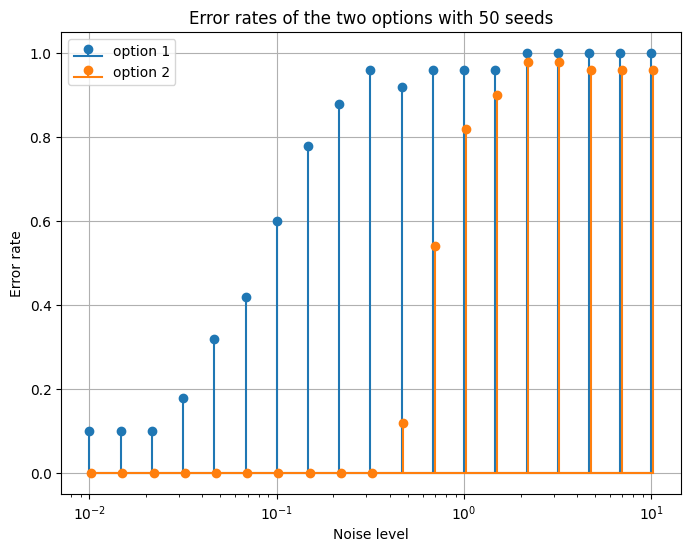

In [55]:
def stem_plot(noise_list, errors_1, errors_2, option_or_method="option", ax=None, ylabel="Error rate", title=True, legend=True):
    # colors
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    # plot rates
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    stem1 = ax.stem(noise_list, errors_1, label=f'{option_or_method} 1')
    plt.setp(stem1.markerline, color=colors[0])  # Set marker color
    plt.setp(stem1.stemlines, color=colors[0])   # Set stem line color
    plt.setp(stem1.baseline, color=colors[0])    # Set baseline color
    epsilon = 2 * 1e-2 * noise_list
    stem2 = ax.stem(noise_list + epsilon, errors_2, label=f'{option_or_method} 2')
    plt.setp(stem2.markerline, color=colors[1])  # Set marker color
    plt.setp(stem2.stemlines, color=colors[1])   # Set stem line color
    plt.setp(stem2.baseline, color=colors[1])    # Set baseline color

    ax.set_xscale("log")
    if legend:
        ax.legend()
    # else:
    #     ax.get_legend().remove()
    if title:
        ax.set_title(f"Error rates of the two {option_or_method}s with {nb_seeds} seeds")
    ax.set_xlabel("Noise level")
    ax.set_ylabel(ylabel)
    ax.grid()
    # plt.show()

stem_plot(noise_list, error_rate_1, error_rate_2)

Obviously, the second option (i.e. average of absolute values) is better than the first option (i.e. absolute value of averages) with these data.

In [56]:
id = np.argmax(error_rate_2 != 0)
noise_1 = noise_list[id-1]
noise_2 = noise_list[id]

print(f"The maximum noise level allowed seems to be between {noise_1:.4f} and {noise_2:.4f}.")

The maximum noise level allowed seems to be between 0.3162 and 0.4642.


The function find_order() is a bit naive because it only looks at row permutations (and not column permutations) and because it iterates over the columns instead of doing a global search, but it seems to work.

Moreover, it's starting not to work when the noise level is between 0.46 and 0.68, just as for the linear sum assignment method used in step 2. So, using a more powerful method to find P would only be useful if we also use more powerful method to find Q.

# method used in LiNGAM's step 5

In [57]:
# functions from github
def _search_causal_order(matrix):
    """Obtain a causal order from the given matrix strictly.

    Parameters
    ----------
    matrix : array-like, shape (n_features, n_samples)
        Target matrix.

    Return
    ------
    causal_order : array, shape [n_features, ]
        A causal order of the given matrix on success, None otherwise.
    """
    causal_order = []

    row_num = matrix.shape[0]
    original_index = np.arange(row_num)

    while 0 < len(matrix):
        # find a row all of which elements are zero
        row_index_list = np.where(np.sum(np.abs(matrix), axis=1) == 0)[0]
        if len(row_index_list) == 0:
            break

        target_index = row_index_list[0]

        # append i to the end of the list
        causal_order.append(original_index[target_index])
        original_index = np.delete(original_index, target_index, axis=0)

        # remove the i-th row and the i-th column from matrix
        mask = np.delete(np.arange(len(matrix)), target_index, axis=0)
        matrix = matrix[mask][:, mask]

    if len(causal_order) != row_num:
        causal_order = None

    return causal_order

def _estimate_causal_order(matrix):
    """Obtain a lower triangular from the given matrix approximately.

    Parameters
    ----------
    matrix : array-like, shape (n_features, n_samples)
        Target matrix.

    Return
    ------
    causal_order : array, shape [n_features, ]
        A causal order of the given matrix on success, None otherwise.
    """
    causal_order = None

    # set the m(m + 1)/2 smallest(in absolute value) elements of the matrix to zero
    pos_list = np.argsort(np.abs(matrix), axis=None)
    pos_list = np.vstack(np.unravel_index(pos_list, matrix.shape)).T
    initial_zero_num = int(matrix.shape[0] * (matrix.shape[0] + 1) / 2)
    for i, j in pos_list[:initial_zero_num]:
        matrix[i, j] = 0

    for i, j in pos_list[initial_zero_num:]:
        causal_order = _search_causal_order(matrix)
        if causal_order is not None:
            break
        else:
            # set the smallest(in absolute value) element to zero
            matrix[i, j] = 0

    return causal_order

In [58]:
# sample data
B_hat, P = sample_data(m, p, noise, rng)
true_order = np.argmax(P, axis=1)

In [59]:
# retrieve order
B_avg = np.mean(np.abs(B_hat), axis=0)
order_lingam = _estimate_causal_order(B_avg)

In [60]:
success = (order_lingam == true_order).all()
if success:
    print("The causal order is retrieved!")
else:
    print("The causal order is not retrieved.")

The causal order is retrieved!


# compare their method with ours

In [61]:
# function that finds P such that P @ B @ P.T is strictly lower triangular
def find_order_2(B_hat):
    _, p, _ = B_hat.shape
    B_avg = np.mean(np.abs(B_hat), axis=0)
    B_sort = np.sort(B_avg, axis=1)[:, ::-1]
    B_argsort = np.argsort(B_sort, axis=0)
    order = []
    for i in range(p):
        col = B_argsort[:, i]
        available_id = ~np.isin(col, order)
        first_id = np.argmax(available_id)
        order.append(col[first_id])
    return order

In [65]:
# main function
def run_experiment_2(noise, random_state, m, p, method):
    # sample data
    B_hat, P = sample_data(m, p, noise, np.random.RandomState(random_state))
    true_order = np.argmax(P, axis=1)
    # find order P
    if method == 1:
        start = time()
        order = find_order_2(B_hat)
        execution_time = time() - start
    else:
        start = time()
        B_avg = np.mean(np.abs(B_hat), axis=0)
        order = _estimate_causal_order(B_avg)
        execution_time = time() - start
    # error
    error = 1 - (order == true_order).all()
    return error, execution_time

In [66]:
# our method
results_1 = np.array([
    run_experiment_2(noise_, random_state_, m, p, method=1)
    for noise_, random_state_
    in product(noise_list, random_state_list)])
results_1 = results_1.reshape(len(noise_list), len(random_state_list), 2)
results_avg_1 = np.mean(results_1, axis=1)

# their method
results_2 = np.array([
    run_experiment_2(noise_, random_state_, m, p, method=2)
    for noise_, random_state_
    in product(noise_list, random_state_list)])
results_2 = results_2.reshape(len(noise_list), len(random_state_list), 2)
results_avg_2 = np.mean(results_2, axis=1)

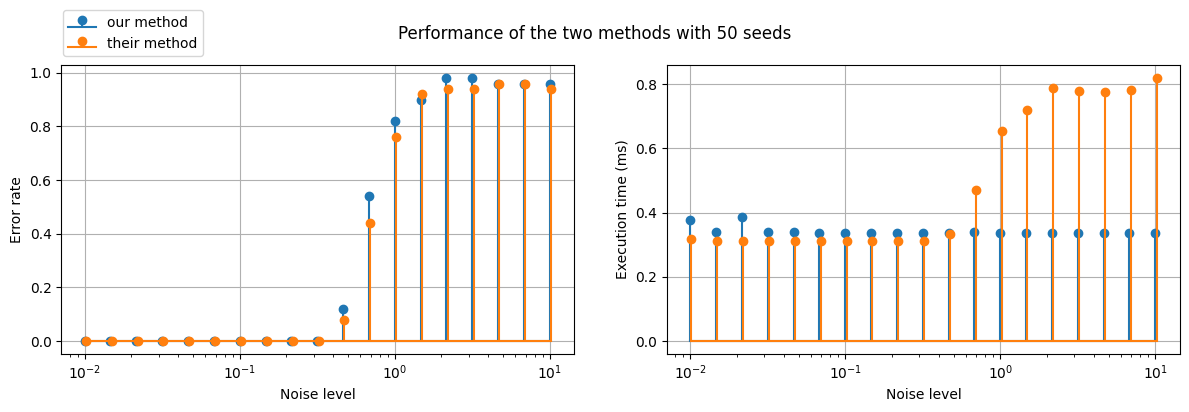

In [67]:
# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
stem_plot(noise_list, results_avg_1[:, 0], results_avg_2[:, 0], option_or_method="method", ax=axes[0], title=False, legend=False)
stem_plot(noise_list, 1e3*results_avg_1[:, 1], 1e3*results_avg_2[:, 1], option_or_method="method", ax=axes[1], ylabel="Execution time (ms)", title=False, legend=False)
handles, _ = axes[0].get_legend_handles_labels()
fig.legend(handles, ["our method", "their method"], bbox_to_anchor=(0.115, 0.96), loc="center", borderaxespad=0.)
fig.suptitle(f"Performance of the two methods with {nb_seeds} seeds")
plt.tight_layout()
plt.subplots_adjust(wspace=0.18)
plt.show()